In [28]:
import alpaca_trade_api as tradeapi
import requests
from dotenv import load_dotenv
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco

plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [29]:
load_dotenv(verbose=True)

True

In [30]:
#alpaca_api_key = os.getenv("ALPACA_API_KEY")
#alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

alpaca_api_key = "PK2QATFJUTTJTLNCCC9E"
alpaca_secret_key = "OpvkG0g84P35EjDZlJZf0fMdJ4ksJiY6YwxNrN4d"
print(alpaca_api_key)

PK2QATFJUTTJTLNCCC9E


In [31]:
def calculate_sharpe_ratio(df):
    
    df_pct_change = df.pct_change()
    #daily_return
    sharpe_ratio = df_pct_change['close'].mean() / df_pct_change['close'].std()
    
    #annualized sharpe ratio
    return (252 ** 0.5) * sharpe_ratio

In [32]:
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Format current date as ISO format
start_date = pd.Timestamp("2011-05-01", tz="America/New_York").isoformat()
today = pd.Timestamp("2021-01-19", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["SPY", "QQQ", "VTI",
           "SPBO", "JNK", "LQD",
           "IYR", "VNQ", "USRT",
           "PSP", "USO", "GLD",
           "MUB", "MUNI", "PZA",
           "VMBS", "MBB", "MBG",
           "TLT", "SCHO", "SHY"
           ]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get closing prices
df_ETFs = alpaca.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = today
).df

#df_ETFs.to_csv("Resources/Data_ETFs_total.csv", encoding='utf-8', index=True) 

In [33]:
sharpe_ratio_list = []
# for each of the tickers, we will calculate the sharpe ratio and store it in a list of dictionaries 
for ticker in tickers:
    sharpe_ratio = calculate_sharpe_ratio(df_ETFs[ticker])
    sharpe_ratio_list.append({"ticker": ticker, "sharpe_ratio" : sharpe_ratio})

# create a data frame with from the list
df_sharpe_ratio= pd.DataFrame(sharpe_ratio_list)
#df_sharpe_ratio

In [34]:
# Set the tickers
tickers = ["QQQ", 
           "LQD",
           "VNQ",
           "USO", 
           "PZA",
           "VMBS",
           "TLT"
           ]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get closing prices
df_ETFs = alpaca.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = today
).df
df_ETFs1 = df_ETFs.dropna()
#df_ETFs1.to_csv("Resources/Data_ETFs_to_use.csv", encoding='utf-8', index=True)

In [35]:
short_window = 50
long_window = 200

df_closing = pd.DataFrame()

df_closing["QQQ"] = df_ETFs1["QQQ"]["close"]
df_closing["LQD"] = df_ETFs1["LQD"]["close"]
df_closing["VNQ"] = df_ETFs1["VNQ"]["close"]
df_closing["USO"] = df_ETFs1["USO"]["close"]
df_closing["PZA"] = df_ETFs1["PZA"]["close"]
df_closing["VMBS"] = df_ETFs1["VMBS"]["close"]
df_closing["TLT"] = df_ETFs1["TLT"]["close"]

df_closing.index = df_closing.index.date
                                   
# Output the data to CSV
#df_closing.to_csv("Resources/Data_ETFs_model_use.csv", encoding='utf-8', index=True)
df_closing

,QQQ,LQD,VNQ,USO,PZA,VMBS,TLT
2011-05-02,58.9924,110.31,61.90,44.9395,22.75,50.7700,93.6300
2011-05-03,58.6900,110.25,61.39,44.1200,22.82,50.8590,94.1500
2011-05-04,58.6000,110.40,61.05,43.2600,22.94,50.8176,94.5900
2011-05-05,58.2800,110.79,60.97,39.3280,23.03,50.9880,95.4600
2011-05-06,58.4800,110.77,60.45,38.8700,23.00,51.0400,95.0701
...,...,...,...,...,...,...,...
2021-01-12,313.9800,135.47,82.10,35.9075,27.04,53.9100,150.9700
2021-01-13,316.0000,136.52,83.17,35.8200,27.09,53.9700,152.6500
2021-01-14,314.2500,135.96,83.65,36.2600,27.05,53.9900,151.2400
2021-01-15,311.9000,136.14,84.63,35.3500,27.10,54.0300,151.8600


In [61]:
# calculate optimal distribution of etf using efficient frontier and scipy's optimize function
# https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f
returns = df_closing.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0

In [62]:
# functions to calculate efficient frontier analysis
# https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((7,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(7)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [65]:
# display function
# https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=df_closing.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=df_closing.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.12
Annualised Volatility: 0.12


              QQQ  LQD  VNQ  USO   PZA  VMBS   TLT
allocation  37.83  0.0  0.0  1.0  7.67   0.0  53.5
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.01
Annualised Volatility: 0.03


             QQQ  LQD  VNQ  USO   PZA   VMBS  TLT
allocation  1.62  0.0  0.0  0.0  2.93  95.45  0.0


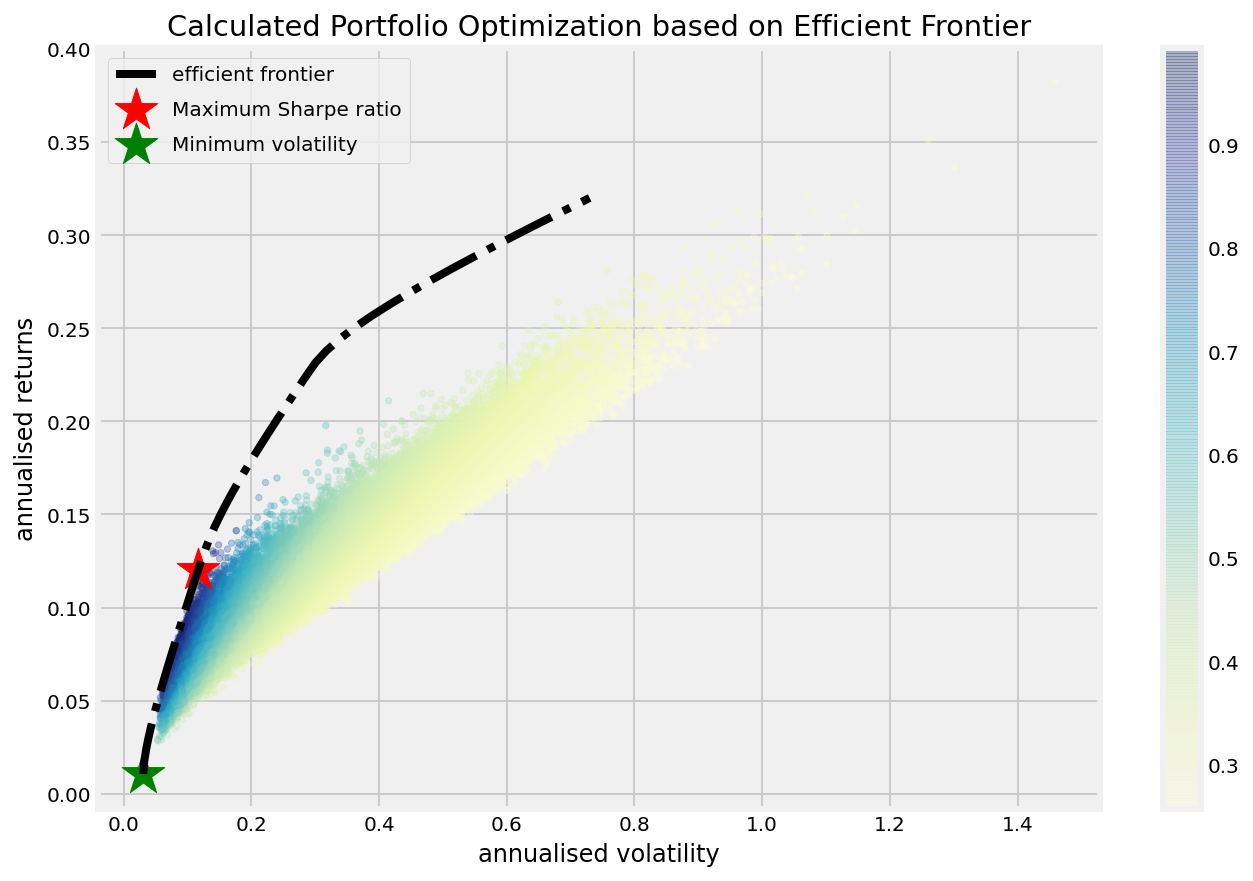

In [66]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)